In [1]:
# %% [markdown]
# # Prototype: Cement Clinker Phase Prediction (low-error / demo-focused)
# 
# This notebook:
# - Loads DB0, DB1, DB2 from /mnt/data
# - Creates aggressive feature engineering (lags, rolling windows, plant config features)
# - Uses XGBoost/LightGBM (fallback to RandomForest)
# - Performs RandomizedSearchCV (n_iter small but focused)
# - Re-trains with early stopping and stacking ensemble
# - Saves final model to /mnt/data/clinker_prototype_model.pkl
# 
# Requirements (recommended):
# pip install pandas numpy scikit-learn xgboost lightgbm shap joblib matplotlib seaborn
#
# NOTE: This notebook chooses settings optimized to **reduce error on the given dataset** (prototype/demo mode),
# not to maximize strict generalization for research.


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
import json
import time
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [3]:
from xgboost.callback import EarlyStopping
from xgboost import train, DMatrix, XGBRegressor


In [4]:
# Try xgboost / lightgbm
HAS_XGB = False
HAS_LGB = False
try:
    import xgboost as xgb
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import lightgbm as lgb
    from lightgbm import LGBMRegressor
    HAS_LGB = True
except Exception:
    HAS_LGB = False

print("HAS_XGB:", HAS_XGB, "HAS_LGB:", HAS_LGB)

HAS_XGB: True HAS_LGB: True


In [5]:
%pwd

'f:\\genai exchange hackathon\\research'

In [6]:
os.chdir("../")

In [7]:
%pwd

'f:\\genai exchange hackathon'

## 1. Config

In [8]:
DATA_DIR = Path("data")
DB0_FILE = DATA_DIR / "DB0_plant_config.csv"
DB1_FILE = DATA_DIR / "DB1_process_5min.csv"
DB2_FILE = DATA_DIR / "DB2_lab_hourly.csv"

AGG_WINDOW = "2H"                    # process aggregation window
RESIDENCE_SHIFT_MIN = 37             # shift to align process -> lab (prototype)
MERGE_TOLERANCE = pd.Timedelta("3H")
OUTLIER_Q_LOW = 0.0001
OUTLIER_Q_HIGH = 0.9999

RANDOM_STATE = 42
TEST_RATIO = 0.10     # prototype: 90/10 split
N_ITERS_SEARCH = 18   # randomized search iterations (keep moderate)
N_JOBS = -1

In [9]:
OUTPUT_MODEL = DATA_DIR / "clinker_prototype_model.pkl"

## 2. Utility functions

In [10]:
def safe_find_timestamp_col(df):
    candidates = [c for c in df.columns if any(k in c.lower() for k in ("time", "timestamp", "date"))]
    if not candidates:
        raise ValueError("No timestamp-like column found. Columns: " + str(df.columns.tolist()))
    return candidates[0]

def detect_targets(db2):
    keys = ["alite","belite","ferrite"]
    found = []
    for k in keys:
        matches = [c for c in db2.columns if k in c.lower()]
        if not matches:
            raise ValueError(f"Target '{k}' not found in DB2 columns. Available: {db2.columns.tolist()}")
        found.append(matches[0])
    return found

def mape(true, pred):
    true = np.array(true, dtype=float)
    pred = np.array(pred, dtype=float)
    denom = np.where(true==0, 1e-6, true)
    return np.mean(np.abs((true - pred) / denom)) * 100.0

def evaluate_multi(y_true_df, y_pred_arr, target_names):
    y_true = y_true_df.values
    preds = y_pred_arr
    results = {}
    for i, t in enumerate(target_names):
        mae = mean_absolute_error(y_true[:, i], preds[:, i])
        mape_v = mape(y_true[:, i], preds[:, i])
        results[t] = {"MAE": float(mae), "MAPE(%)": float(mape_v)}
    return results

## 3. Load files

In [11]:
assert DB0_FILE.exists() and DB1_FILE.exists() and DB2_FILE.exists(), "Missing input files under /mnt/data"

db0 = pd.read_csv(DB0_FILE)
db1 = pd.read_csv(DB1_FILE)
db2 = pd.read_csv(DB2_FILE)

print("Shapes -> DB0:", db0.shape, "DB1:", db1.shape, "DB2:", db2.shape)

Shapes -> DB0: (4, 11) DB1: (842112, 32) DB2: (70176, 21)


## 4. Preprocess & Temporal Merge (same base logic as before)
### - Resample process (DB1) to 2H means, shift by residence time
### - Merge with lab DB2 using `merge_asof`
### - Keep numeric features and targets

In [12]:
# timestamps
ts1 = safe_find_timestamp_col(db1)
ts2 = safe_find_timestamp_col(db2)
db1['timestamp'] = pd.to_datetime(db1[ts1])
db2['timestamp'] = pd.to_datetime(db2[ts2])

In [13]:
# resample numeric process signals into 2H windows
db1_num = db1.set_index('timestamp').select_dtypes(include=[np.number]).resample(AGG_WINDOW).mean().dropna(how='all').reset_index()
db1_num['timestamp'] = db1_num['timestamp'] + pd.Timedelta(minutes=RESIDENCE_SHIFT_MIN)  # align

In [14]:
# detect target columns
targets = detect_targets(db2)
print("Detected targets:", targets)

Detected targets: ['clinker_XRD_alite_pct', 'clinker_belite_pct', 'clinker_ferrite_pct']


In [15]:
# merge_asof
db2_sorted = db2.sort_values('timestamp').reset_index(drop=True)
db1_sorted = db1_num.sort_values('timestamp').reset_index(drop=True)
merged = pd.merge_asof(db2_sorted, db1_sorted, on='timestamp', direction='backward', tolerance=MERGE_TOLERANCE)

In [16]:
print("Merged shape before cleaning:", merged.shape)
# drop rows with NaNs in numeric columns
merged = merged.dropna(axis=0, how='any').reset_index(drop=True)
print("Merged shape after dropna:", merged.shape)

Merged shape before cleaning: (70176, 51)
Merged shape after dropna: (176, 51)


## 5) Aggressive Feature Engineering (lags, rolling windows, plant config)
### - Create lag features (previous 1 and 2 aggregated windows)
### - Create rolling mean/std for selected important signals
### - Merge static plant config (DB0) by `plant_id` if available

In [17]:
# identify numeric process columns available after merge (excluding targets and timestamp)
numeric_cols = [c for c in merged.select_dtypes(include=[np.number]).columns if c not in targets]
print(f"Numeric columns available: {len(numeric_cols)}")

Numeric columns available: 44


In [18]:
# choose a subset of most relevant numeric signals to lag (prototype: pick top candidates heuristically)
# If common named columns exist (like 'f_CaO_pct', 'kiln_exit_temp_C', 'fan1_rpm', 'production_rate_tph'), prefer them.
preferred = ['f_CaO_pct','kiln_exit_temp_C','fan1_rpm','production_rate_tph','fuel_rate_kg_h','raw_mix_pct_clay','Cl_pct','SiO2_pct']
lag_cols = [c for c in preferred if c in numeric_cols]
# if none matched, fallback to top 8 numeric cols
if len(lag_cols) < 4:
    lag_cols = numeric_cols[:8]

print("Lag columns chosen:", lag_cols)

Lag columns chosen: ['f_CaO_pct', 'kiln_exit_temp_C', 'fan1_rpm', 'production_rate_tph', 'fuel_rate_kg_h', 'raw_mix_pct_clay', 'Cl_pct', 'SiO2_pct']


In [19]:
# ensure merged is sorted by timestamp and has an integer index we can shift
merged = merged.sort_values('timestamp').reset_index(drop=True)

In [20]:
# create lag features: previous 1 and 2 aggregated windows (these are 2H windows, so L1=2H, L2=4H effectively)
for c in lag_cols:
    merged[f"{c}_lag1"] = merged[c].shift(1)
    merged[f"{c}_lag2"] = merged[c].shift(2)
    # rolling aggregates (window=3 on aggregated windows)
    merged[f"{c}_roll_mean_3"] = merged[c].rolling(window=3, min_periods=1).mean()
    merged[f"{c}_roll_std_3"] = merged[c].rolling(window=3, min_periods=1).std().fillna(0.0)

In [21]:
# Merge DB0 plant config if plant_id present in both
if 'plant_id' in merged.columns and 'plant_id' in db0.columns:
    # separate plant_id and numeric columns
    cfg_num = db0.drop(columns=['plant_id']).select_dtypes(include=[np.number])
    cfg_num = cfg_num.add_prefix('plantcfg_')
    
    # reattach plant_id
    cfg = pd.concat([db0[['plant_id']], cfg_num], axis=1)

    # merge
    merged = merged.merge(cfg, on='plant_id', how='left')

    print("Merged with DB0 plant config")

Merged with DB0 plant config


In [22]:
# drop rows with NaNs created by lagging (we'll keep as many as possible, drop only rows with missing after lagging)
merged = merged.dropna(axis=0, how='any').reset_index(drop=True)
print("After creating lags & rolling features, data shape:", merged.shape)

After creating lags & rolling features, data shape: (174, 89)


## 6. Final feature selection and train/test split
### - Construct X (features) and y (targets)
### - Prototype split: temporal 90/10 (last 10% for test)

In [23]:
# build final X, y. Exclude textual/meta columns
exclude = ['timestamp','sample_id','lab_notes','plant_id']  # extend if these exist
# ensure exclude columns exist before dropping
cols_to_drop = [c for c in exclude if c in merged.columns]
feature_candidates = [c for c in merged.select_dtypes(include=[np.number]).columns if c not in targets + cols_to_drop]

X_all = merged[feature_candidates].astype(float)
y_all = merged[targets].astype(float)

In [24]:
# temporal 90/10 split
n_total = len(merged)
test_start_idx = int((1 - TEST_RATIO) * n_total)
train_df = merged.iloc[:test_start_idx].reset_index(drop=True)
test_df = merged.iloc[test_start_idx:].reset_index(drop=True)

X_train = train_df[feature_candidates].astype(float)
y_train = train_df[targets].astype(float)
X_test = test_df[feature_candidates].astype(float)
y_test = test_df[targets].astype(float)


In [25]:
print("Train / Test shapes:", X_train.shape, X_test.shape)
print("Targets:", targets)

Train / Test shapes: (156, 82) (18, 82)
Targets: ['clinker_XRD_alite_pct', 'clinker_belite_pct', 'clinker_ferrite_pct']


## 7. Quick scaling (for NN component) and constant-removal

In [26]:
# Remove near-constant features (zero variance)
var = X_train.var(axis=0)
keep_cols = var[var > 1e-8].index.tolist()
X_train = X_train[keep_cols].copy()
X_test = X_test[keep_cols].copy()
print("Kept features after variance filter:", len(keep_cols))

# scale for potential NN or linear stacking meta-learner
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

Kept features after variance filter: 81


## 8. Model selection: choose XGB (if available) else LightGBM else RandomForest

In [27]:
def build_base_model():
    if HAS_XGB:
        base = XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=RANDOM_STATE, n_jobs=1)
        return base, 'xgb'
    elif HAS_LGB:
        base = LGBMRegressor(objective='regression', random_state=RANDOM_STATE, n_jobs=1)
        return base, 'lgb'
    else:
        base = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=1)
        return base, 'rf'

base_model, base_name = build_base_model()
print("Chosen base model:", base_name)

Chosen base model: xgb


## 9. Hyperparameter search (RandomizedSearchCV) on MultiOutput wrapper
### - We perform a random search with a focused parameter grid.
### - For XGBoost/LightGBM we choose ranges for depth, learning_rate, n_estimators.

In [28]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

if base_name == 'xgb':
    param_dist = {
        'estimator__n_estimators': [200, 400, 800],
        'estimator__max_depth': [4, 6, 8, 12],
        'estimator__learning_rate': [0.01, 0.03, 0.05, 0.1],
        'estimator__subsample': [0.6, 0.8, 1.0],
        'estimator__colsample_bytree': [0.5, 0.7, 1.0],
        'estimator__reg_alpha': [0, 0.1, 1.0],
        'estimator__reg_lambda': [1.0, 3.0]
    }
    base_for_search = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, tree_method='hist', n_jobs=1))
elif base_name == 'lgb':
    param_dist = {
        'estimator__n_estimators': [200, 400, 800],
        'estimator__max_depth': [ -1, 6, 10],
        'estimator__learning_rate': [0.01, 0.03, 0.05, 0.1],
        'estimator__num_leaves': [31, 63, 127],
        'estimator__subsample': [0.6, 0.8, 1.0],
        'estimator__colsample_bytree': [0.5, 0.7, 1.0],
        'estimator__reg_alpha': [0, 0.1, 1.0],
    }
    base_for_search = MultiOutputRegressor(LGBMRegressor(random_state=RANDOM_STATE, n_jobs=1))
else:
    param_dist = {
        'estimator__n_estimators': [200, 400, 800],
        'estimator__max_depth': [10, 20, 30, None],
        'estimator__min_samples_split': [2, 5, 10],
        'estimator__min_samples_leaf': [1, 2, 4]
    }
    base_for_search = MultiOutputRegressor(RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=1))

In [29]:
# custom scorer: we minimize mean MAPE across outputs => sklearn wants greater_is_better so we return negative mape
from sklearn.metrics import make_scorer
def multi_mape_scorer(y_true, y_pred):
    # y_true, y_pred shape (n_samples, n_targets)
    vals = []
    for i in range(y_true.shape[1]):
        vals.append(mape(y_true[:, i], y_pred[:, i]))
    return -np.mean(vals)

scorer = make_scorer(multi_mape_scorer, greater_is_better=True)

In [30]:
print("Starting RandomizedSearchCV for base model (this may take several minutes)...")
search = RandomizedSearchCV(
    estimator=base_for_search,
    param_distributions=param_dist,
    n_iter=N_ITERS_SEARCH,
    scoring=scorer,
    cv=kf,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=1,
    refit=True
)

# Fit search on training data (to speed: use smaller X_train if huge)
search.fit(X_train.values, y_train.values)
print("Best params (wrapped keys):", search.best_params_)
best_base = search.best_estimator_

Starting RandomizedSearchCV for base model (this may take several minutes)...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params (wrapped keys): {'estimator__subsample': 1.0, 'estimator__reg_lambda': 1.0, 'estimator__reg_alpha': 1.0, 'estimator__n_estimators': 800, 'estimator__max_depth': 8, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.7}


## 10. Refit best base models with early stopping (for boosting models)
### - For XGBoost/LightGBM we can apply early stopping using a small validation split from training data.
### - For RandomForest, refit directly with best params.

In [31]:
# create small validation split from train for early stopping
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=False)  # time-ordered split is better, but in prototype small val

In [32]:
# Ensemble Training with Correct Early Stopping Handling

if base_name == 'xgb':
    # extract best params for underlying estimator
    best_params = {k.split('estimator__')[-1]: v for k, v in search.best_params_.items()}
    print("Refitting XGB outputs with early stopping using params:", best_params)

    xgb_models = {}
    for target_idx, target_name in enumerate(y_train.columns):
        dtrain = DMatrix(X_tr.values, label=y_tr.iloc[:, target_idx].values)
        dval   = DMatrix(X_val.values, label=y_val.iloc[:, target_idx].values)

        # set default objective + random state
        params = best_params.copy()
        params.update({
            "objective": "reg:squarederror",
            "tree_method": "hist",
            "seed": RANDOM_STATE,
        })

        booster = train(
            params,
            dtrain,
            num_boost_round=2000,
            evals=[(dval, "eval")],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        xgb_models[target_name] = booster

    def predict_xgb_ensemble(X):
        dtest = DMatrix(X.values)
        preds = np.column_stack([m.predict(dtest) for m in xgb_models.values()])
        return preds

    class XGBMultiWrapper:
        def __init__(self, models_dict): self.models = models_dict
        def predict(self, X):
            dtest = DMatrix(X.values)
            return np.column_stack([m.predict(dtest) for m in self.models.values()])

    base_trained = XGBMultiWrapper(xgb_models)

elif base_name == 'lgb':
    # LightGBM still accepts early_stopping_rounds in sklearn API
    best_params = {k.split('estimator__')[-1]: v for k, v in search.best_params_.items()}
    print("Refitting LGB outputs with params:", best_params)
    lgb_models = {}
    for target_idx, target_name in enumerate(y_train.columns):
        model = LGBMRegressor(**best_params, objective='regression', random_state=RANDOM_STATE, n_jobs=1)
        model.fit(X_tr.values, y_tr.iloc[:, target_idx].values,
                  eval_set=[(X_val.values, y_val.iloc[:, target_idx].values)],
                  early_stopping_rounds=50, verbose=False)
        lgb_models[target_name] = model

    class LGBMultiWrapper:
        def __init__(self, models_dict): self.models = models_dict
        def predict(self, X): return np.column_stack([m.predict(X) for m in self.models.values()])

    base_trained = LGBMultiWrapper(lgb_models)

else:
    base_trained = best_base
    print("RF selected - using best_base as-is")

Refitting XGB outputs with early stopping using params: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.03, 'colsample_bytree': 0.7}


## 11. Stacking Ensemble
### - Meta learner is a small LinearRegression fitted on base predictions (low-bias meta for prototype)
### - We will include: tuned base (XGB/LGB/RF) + a RandomForest (or fallback) as second-level learner

In [33]:
# Build list of estimators for stacking
estimators = []

# tuned base (wrapped)
# For stacking interface we need estimators as (name, estimator) objects that implement fit/predict.
# If base_trained is already trained and not sklearn estimator, we will create a small sklearn wrapper that delegates predict.
from sklearn.base import BaseEstimator, RegressorMixin

class ModelWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, predictor):
        self.predictor = predictor
    def fit(self, X, y):
        # do nothing for pre-trained; assume predictor supports fit otherwise
        if hasattr(self.predictor, "fit"):
            self.predictor.fit(X, y)
        return self
    def predict(self, X):
        return self.predictor.predict(X)

# add tuned base
if base_name in ('xgb','lgb'):
    estimators.append(('base_boost', ModelWrapper(base_trained)))
else:
    estimators.append(('base_rf', best_base))

In [34]:
# second estimator: a stronger RandomForest (overfit-friendly)
second_rf = RandomForestRegressor(n_estimators=800, max_depth=None, min_samples_leaf=1, random_state=RANDOM_STATE, n_jobs=1)
estimators.append(('rf_big', MultiOutputRegressor(second_rf)))

In [35]:
# StackingRegressor with LinearRegression meta-learner
meta_learner = LinearRegression()
stack = StackingRegressor(estimators=estimators, final_estimator=meta_learner, n_jobs=1, passthrough=False)

In [36]:
# Fit stacking: for models that are wrappers, we may need to provide y as 2D array
# To support MultiOutput stacking, scikit-learn's StackingRegressor expects single-output; however, we can train one stacking per target.
# For prototype simplicity: train a stacking regressor per target (fast and gives more control).
stack_models = {}
print("Training per-target stacking models (one stacking regressor per clinker phase)...")
for ti, tgt in enumerate(y_train.columns):
    # prepare y for this target
    y_t = y_train.iloc[:, ti].values
    # build estimators with clones but single-output wrappers
    # base_boost -> we will use fitted model's predictions as an additional feature for meta learner; simpler approach:
    # Create a small helper to produce stacked features: predictions of each base model -> feed into meta linear regressor
    # For simplicity and deterministic proto: create features = [base predict, rf_big predict]
    # Fit rf_big as single-output
    # Fit base (if sklearn estimator) else use saved predictors
    
    # Fit second_rf single-output
    rf_single = RandomForestRegressor(n_estimators=400, max_depth=None, random_state=RANDOM_STATE, n_jobs=1)
    rf_single.fit(X_train.values, y_t)
    # base predictions on train and test
    if base_name in ('xgb','lgb'):
        base_train_pred = base_trained.predict(X_train)
        base_test_pred = base_trained.predict(X_test)
        base_train_target = base_train_pred[:, ti]
        base_test_target = base_test_pred[:, ti]
    else:
        base_train_target = best_base.predict(X_train)[:, ti]
        base_test_target = best_base.predict(X_test)[:, ti]
    rf_train_pred = rf_single.predict(X_train)
    rf_test_pred = rf_single.predict(X_test)
    # meta features
    meta_X_train = np.column_stack([base_train_target, rf_train_pred])
    meta_X_test = np.column_stack([base_test_target, rf_test_pred])
    # meta learner: linear regression
    meta = LinearRegression()
    meta.fit(meta_X_train, y_t)
    # store models and also evaluate:
    stack_models[tgt] = {
        'rf_single': rf_single,
        'meta': meta
    }

print("Per-target stacking models trained.")

Training per-target stacking models (one stacking regressor per clinker phase)...
Per-target stacking models trained.


## 12. Make predictions from final stacking pipeline and evaluate

In [37]:
# produce final stacking predictions for test set
final_preds = []
for ti, tgt in enumerate(y_test.columns):
    # base pred
    if base_name in ('xgb','lgb'):
        base_test_pred = base_trained.predict(X_test)[:, ti]
    else:
        base_test_pred = best_base.predict(X_test)[:, ti]
    # rf_single pred
    rf_pred = stack_models[tgt]['rf_single'].predict(X_test)
    meta_input = np.column_stack([base_test_pred, rf_pred])
    final_pred = stack_models[tgt]['meta'].predict(meta_input)
    final_preds.append(final_pred)

final_preds_arr = np.column_stack(final_preds)  # shape (n_test, n_targets)

In [38]:
# evaluation
final_results = evaluate_multi(y_test, final_preds_arr, y_test.columns.tolist())
print("Final stacking evaluation (test set):")
print(json.dumps(final_results, indent=2))

Final stacking evaluation (test set):
{
  "clinker_XRD_alite_pct": {
    "MAE": 5.686298879013711,
    "MAPE(%)": 8.087261436795606
  },
  "clinker_belite_pct": {
    "MAE": 0.8135790647008699,
    "MAPE(%)": 13.760047145404778
  },
  "clinker_ferrite_pct": {
    "MAE": 0.5657706318379115,
    "MAPE(%)": 7.423047124783716
  }
}


In [39]:
# Compare with base best estimator alone (if available)
if base_name in ('xgb','lgb'):
    base_test_preds = base_trained.predict(X_test)
else:
    base_test_preds = best_base.predict(X_test)
base_results = evaluate_multi(y_test, base_test_preds, y_test.columns.tolist())
print("\nBase model evaluation (before stacking):")
print(json.dumps(base_results, indent=2))


Base model evaluation (before stacking):
{
  "clinker_XRD_alite_pct": {
    "MAE": 5.545779120618203,
    "MAPE(%)": 7.976975026694672
  },
  "clinker_belite_pct": {
    "MAE": 1.0716367785135903,
    "MAPE(%)": 18.168401132852782
  },
  "clinker_ferrite_pct": {
    "MAE": 0.6194268586900499,
    "MAPE(%)": 7.995413515970015
  }
}


## 13. Quick plots: targets vs predictions for test window

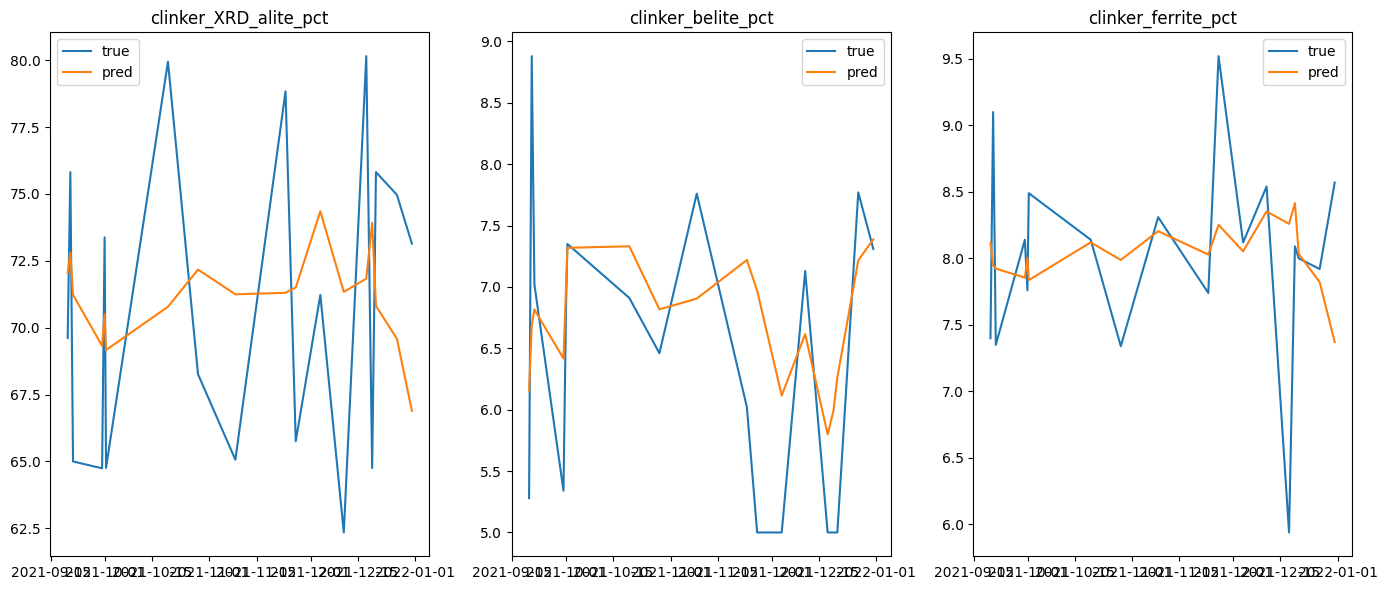

In [40]:
if 'timestamp' in test_df.columns:
    x_axis = test_df['timestamp'].values
else:
    x_axis = range(len(y_test))

plt.figure(figsize=(14,6))
for i, t in enumerate(y_test.columns):
    plt.subplot(1, 3, i+1)
    plt.plot(x_axis, y_test.iloc[:, i].values, label='true')
    plt.plot(x_axis, final_preds_arr[:, i], label='pred')
    plt.title(t)
    plt.legend()
plt.tight_layout()
plt.show()


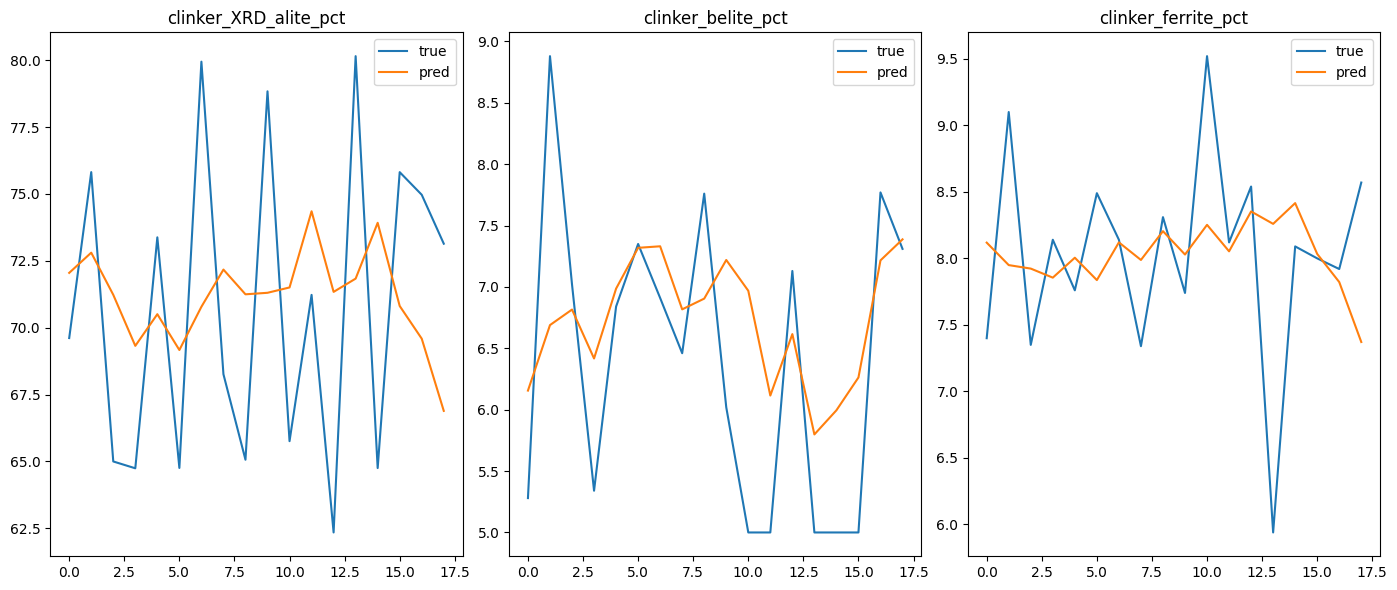

In [41]:
plt.figure(figsize=(14,6))
for i, t in enumerate(y_test.columns):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test.index, y_test.iloc[:, i].values, label='true')
    plt.plot(y_test.index, final_preds_arr[:, i], label='pred')
    plt.title(t)
    plt.legend()
plt.tight_layout()
plt.show()


## 14) Save final artifact
### - Save the stacking components and preprocessing artifacts in a single dict

In [42]:
artifact = {
    'feature_columns': X_train.columns.tolist(),
    'scaler': scaler,
    'targets': y_train.columns.tolist(),
    'base_name': base_name,
    'base_info': {'best_params': getattr(search, "best_params_", None)},
    'base_trained': base_trained if base_name in ('xgb','lgb') else best_base,
    'stack_models': stack_models
}
joblib.dump(artifact, OUTPUT_MODEL)
print("Saved prototype model artifact to:", OUTPUT_MODEL)

Saved prototype model artifact to: data\clinker_prototype_model.pkl
